In [2]:
from optical_lattice import GeneratedLatticeImage

## Generate Mimic Data

Before analyzing real data, it is useful to test the generative model on well behaved mimic data. For this, we use the `GenerateLatticeImage` object.

Given a number of lattice sites and number of pixels per lattice site, as well as a total CCD sidelength, an array is generated which mimics the CCD output for real data. On this array, a specified number of atoms are uniformly and randomly placed within the optical lattice region. From those atoms, assuming that they are Gaussian emitters, some number of photons are sampled. To simulate spurious photons on the camera, some number counts are drawn from a Poisson distribution, and they are uniformly and randomly placed on the lattice and the rest of the CCD.

Specify parameters to generate data:

In [3]:
N = 15 #Number of lattice sites along each axis
M = 10 #Number of pixels per lattice site
N_atom = 150 #Number of atoms to be randomly placed
N_photon = 50 #Number of photons atoms fluoresce
std = 3 #Width of the normal distribution that counts are sampled from
lam_backg = 10000 #Expectation interval of the Poisson dark count event

Generate the data with specified parameters

In [4]:
lattice_image = GeneratedLatticeImage(
    N=N,
    M=M,
    N_atom=N_atom,
    N_photon=N_photon,
    std=std,
    lam_backg=lam_backg,
    CCD_resolution=N*M,
    lattice_origin=(0,0)
)

Visualize the generated data

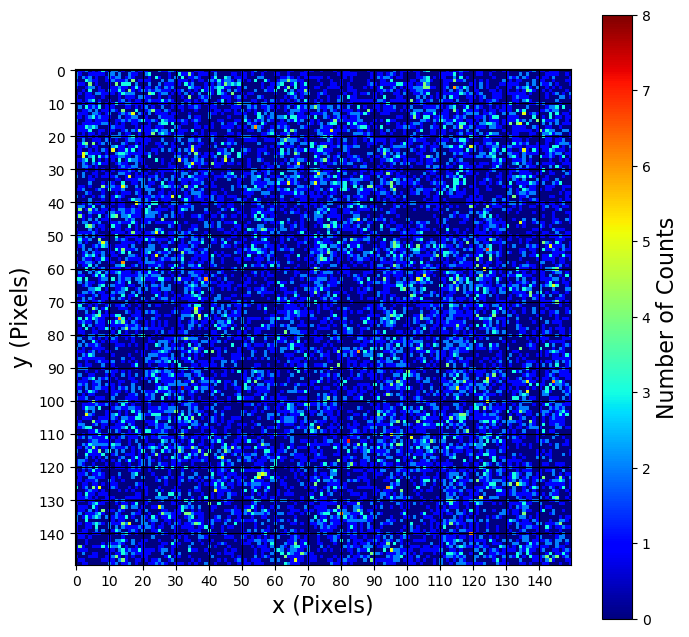

In [5]:
lattice_image.grid_plot()

Generated data also gives the actual, binary distribution of atoms on the lattice with `lattice_image.actual_lattice`

## Analysis

To analyze the generated data and find the probability of occupation by an atom for each lattice site a generative mixture model is used on `pymc3`. The log-likelihood for that model is defined as:

$$ \log(L) = q \log{N(\mu_a, \sigma_a)} + (1-q)\log{N(\mu_b, \sigma_b)} $$

where $N(\mu_a, \sigma_a)$ and $N(\mu_b, \sigma_b)$ are the generative models for the atoms and the background (spurious photons) respectively. Here $\mu_a$ and $\mu_b$ are given as:

$$ \mu_a = A_a \exp\left(-\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}\right) $$
$$ \mu_b = A_b U((x_0,x_1),(y_0,y_1)) $$

where the point spread function for the atoms, $\mu_a$ is modelled as 2D Gaussian centered at $x_c,y_c$ with a width and amplitude of $\sigma$ and $A_a$ and the background $\mu_b$ is modelled as a uniform distribution in a given range with the amplitude $A_b$. Finally the generative models have a Gaussian uncertainty of $\sigma_a$ and $\sigma_b$ for the atoms and the background respectively.

The model analyzes a 2D image of photon counts for the whole lattice. It uses a prior probability $P$ corresponding to the occupation probability of the whole lattice to generate an array of Boolean numbers, $q$. Those $q$ numbers are drawn from a Bernouilli distribution with the probability $P$ and the number $q_{ij}$ is 1 if the lattice site $ij$ is occuiped and 0 if not. Then, the model places an array of Gaussians with an amplitude $A_a$ to lattice sites $ij$ for $q_{ij}=1$. Likewise the model places an array of uniform distributions with an amplitude $A_b$ to lattice sites $ij$ for $q_{ij}=0$. The amplitude are also assigned as model parameters with uniform prior probabilities. Finally, the log-likelihood is modelled by adding those two arrays for the atoms and the background. 

The samples are drawn from this log-likelihood and posterior probability is marginalized over all parameters but $q$'s which correspond to the occupation numbers for the lattice sites.

In [6]:
from optical_lattice import mixture_model
from optical_lattice import LatticeImageAnalyzer
import seaborn as sns

Specify the model for the anmixture_model_v1the data with that model given the generated data results

In [7]:
# Instantiate the Analyzer with the lattice_image object created above
q = LatticeImageAnalyzer(lattice_image)

# Run analysis
%time q.sample_mixture_model(mixture_model, nsteps = 750, nchains = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma_b, sigma_a, std, Ab, Aa, q]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.95draws/s]


Wall time: 1min 20s


The model yields the mean q value for each lattice site which weights the Gaussian modelling the atoms.

In [8]:
q.print_occupation()

[[0.753 0.913 0.83  0.763 0.909 0.407 0.836 0.33  0.396 0.706 0.905 0.863
  0.403 0.74  0.416]
 [0.827 0.825 0.881 0.487 0.486 0.862 0.79  0.806 0.822 0.486 0.815 0.889
  0.788 0.836 0.83 ]
 [0.89  0.941 0.382 0.857 0.754 0.451 0.887 0.847 0.518 0.721 0.61  0.777
  0.87  0.856 0.803]
 [0.427 0.869 0.767 0.846 0.425 0.847 0.76  0.846 0.836 0.875 0.468 0.8
  0.366 0.868 0.4  ]
 [0.748 0.904 0.828 0.486 0.437 0.824 0.497 0.728 0.886 0.448 0.409 0.371
  0.817 0.434 0.483]
 [0.897 0.743 0.837 0.878 0.443 0.874 0.42  0.92  0.674 0.884 0.773 0.85
  0.908 0.515 0.749]
 [0.825 0.823 0.83  0.932 0.435 0.374 0.451 0.83  0.437 0.725 0.853 0.889
  0.856 0.815 0.876]
 [0.91  0.81  0.396 0.827 0.754 0.472 0.793 0.463 0.43  0.767 0.777 0.777
  0.895 0.365 0.483]
 [0.761 0.366 0.827 0.835 0.603 0.433 0.681 0.52  0.863 0.885 0.679 0.879
  0.423 0.425 0.78 ]
 [0.746 0.477 0.898 0.908 0.513 0.786 0.427 0.48  0.498 0.89  0.502 0.92
  0.815 0.721 0.853]
 [0.742 0.913 0.869 0.899 0.379 0.417 0.878 0.81  0.38

We can plot the histogram of mean q values to pick a threshold for binarization.

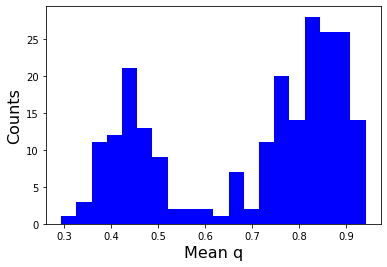

In [9]:
q.plot_histogram()

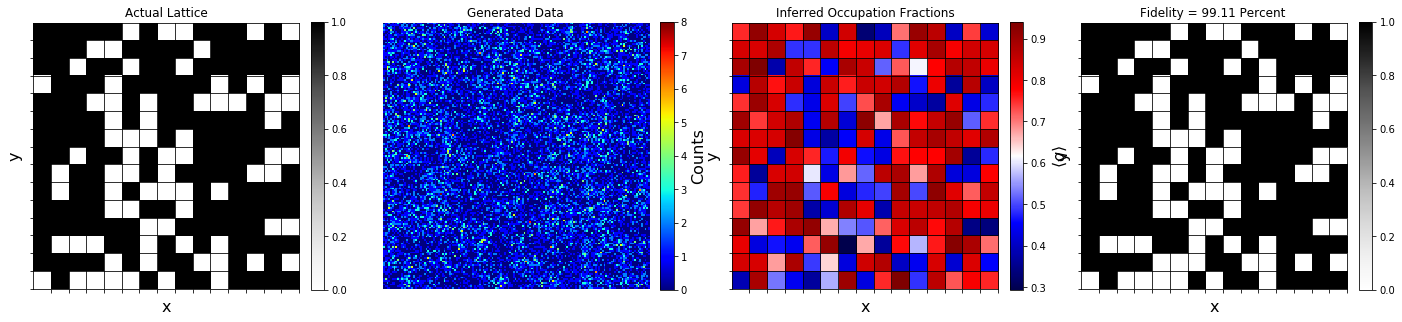

In [10]:
q.plot_occupation(threshold = 0.65)

The uncertainty of this estimate is related to the width of the q values for each site. An example of plotting two of these marginalized distributions is given below. For each lattice site there is a such a distribution.

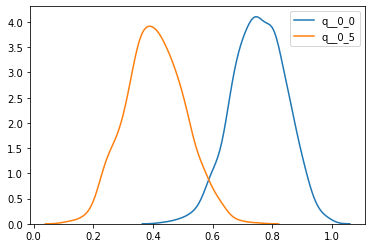

In [12]:
sns.kdeplot(data=q.df.q__0_0);
sns.kdeplot(data=q.df.q__0_5);

# Analysis of the Real Data with Deconvolution

Raw data consists of 6 lattice shots and a PSF. Data is collected with a high-resolution objective and an EMCDD camera. Analysis starts with selecting a region of interest. Then image is rotated such that the lattice is oriented vertically. Then Wiener-Hunt deconvolution is performed given the point-spread function. After this the deconvoluted image is shifted such that atom centers match the lattice locations of the lattice. Finally, photon counts on lattice sites are histogrammed and a threshold is calculated. With this threshold the deconvoluted image is binarized and the occupation numbers on each lattice is found.

## Wiener-Hunt Deconvolution (source: Wikipedia)

Given a system:

$$ y(t) = (h*x)(t) + n(t) $$

- $x(t)$ is some original signal (unknown) at time t
- $h(t)$ is the known impulse response (PSF) of a system
- $n(t)$ is some unknown additive noise
- $y(t)$ is our observed signal

Our goal is to find some $g(t)$ so that we can estimate $x(t)$.

$\hat{x}(t) = (g*y)(t)$

where $\hat{x}(t)$ is an estimate of $x(t)$ that minimizes the mean square error.

The Wiener deconvolution filter provides such a $g(t)$.  The filter is most easily described in the frequency domain:

$$ G(f) = \frac{H^*(f)S(f)}{ |H(f)|^2 S(f) + N(f) } $$

The filtering operation may either be carried out in the time-domain, as above, or in the frequency domain:

$$ \hat{X}(f) = G(f)Y(f) $$

and then performing an inverse Fourier transform on $\hat{X}(f)$ to obtain $\hat{x}(t)$.

In [10]:
from optical_lattice import ConvolutionLatticeImageAnalyzer 
from pathlib import Path
import os

Paths for the raw data is assigned, the shot to be analyzed is specified:

In [11]:
raw_image_path = Path('data/Scan-20200201-0006.hdf')

# Different operating systems have different end of line conventions
if os.name == 'nt':
    # Windows
    psf_path = Path('data/20191216-0030_win10.pkl')
else:
    # other (unix)
    psf_path = Path('data/20191216-0030.pkl')
    
shot_number = 4

Analysis parameters:
Traditionally, these parameters would be found manually by trial, error, and human inspection. It is truly an image processing approach in that it aims to produce an image which is easily interpretted by humans at the sacrifice of statistical clarity. For example, manually choosing the threshold buffer value allows the user to control how much light in a site qualifies as occupation.

In [12]:
M = 10 #Number of pixels per lattice site
angle = 47.5 #Angle by which the raw image is rotated
roi = [650, 1050, 720, 1120] #[x1,x2,y1,y2] Region of interest of the raw image
shift_up = 5 #Number of pixels by which the deconvolved image is shifted up such that atom locations match the lattice sites
shift_left = 0 #Number of pixels by which the deconvolved image is shifted left such that atom locations match the lattice sites
threshold_buffer = 0.5 #Threshold buffer to be added to the calculated threshold for binarizing the deconvolved image

In [ ]:
single_site_image = ConvolutionLatticeImageAnalyzer(
    raw_image_path = raw_image_path,
    shot_number = shot_number,
    psf_path = psf_path,
    M=M,
    angle=angle,
    roi=roi,
    shift_up=shift_up,
    shift_left=shift_left, 
    threshold_buffer=threshold_buffer
)

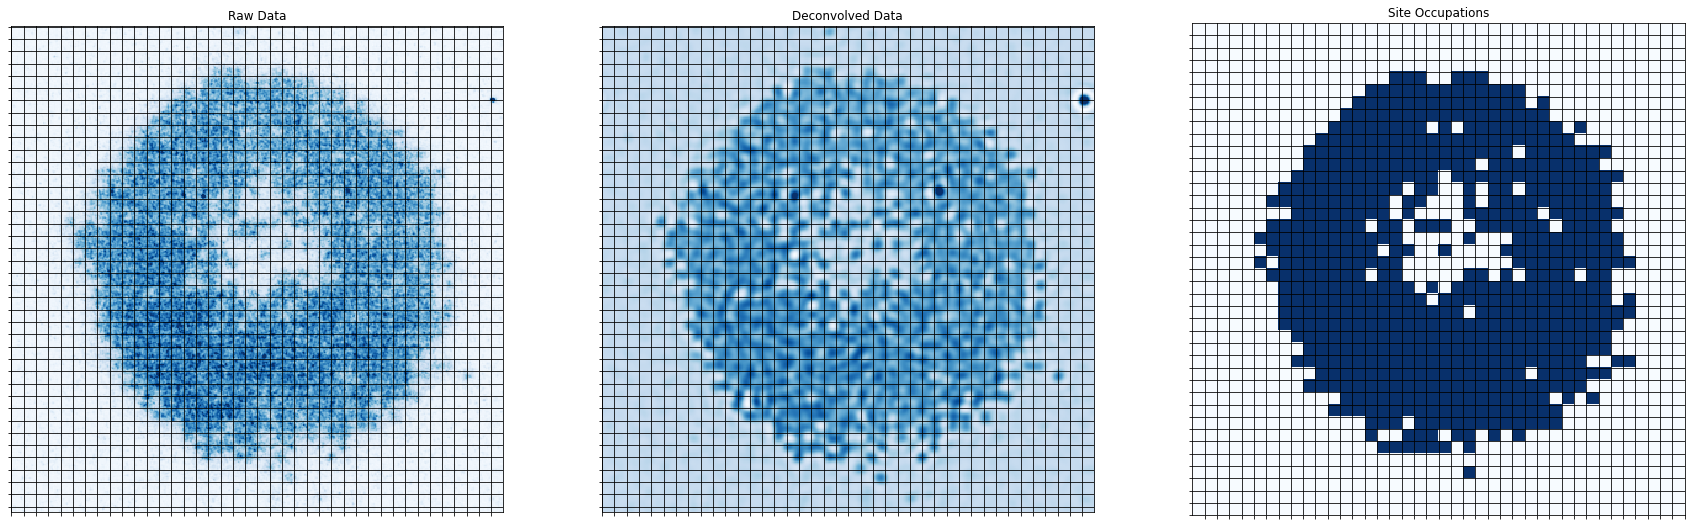

In [11]:
binarized = single_site_image.analyze_raw_data(plot=True, plot_hist=False) 